In [13]:
!pip install -q tensorflow matplotlib numpy
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [14]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!cp "/content/drive/MyDrive/Maize.zip" /content/


In [6]:
!unzip -q /content/Maize.zip -d /content/maize_data

In [11]:
image_size = 224
batch_size = 32
epochs = 25
base_dir = "/content/maize_data/Maize"  # Update with your path

In [8]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [9]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)


In [15]:
# Load datasets
train_data = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 19426 images belonging to 7 classes.


In [16]:
test_data = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # Important for confusion matrix
)

Found 5125 images belonging to 7 classes.


In [17]:
categories = list(train_data.class_indices.keys())
with open('class_indices.json', 'w') as f:
    json.dump(train_data.class_indices, f)

print("Class mapping:", train_data.class_indices)


Class mapping: {'fall armyworm': 0, 'grasshoper': 1, 'healthy': 2, 'leaf beetle': 3, 'leaf blight': 4, 'leaf spot': 5, 'streak virus': 6}


In [19]:
base_model = tf.keras.applications.MobileNet(
    weights="imagenet",
    include_top=False,
    input_shape=(image_size, image_size, 3)
)
base_model.trainable = False  # Freeze base layers

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(len(categories), activation='softmax')(x)

model = keras.Model(inputs, x, name="MaizeDisease_MobileNet")

In [22]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy",
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

model.summary()

Model: "MaizeDisease_MobileNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,360,967 (12.82 MB)

 Trainable params: 132,103 (516.03 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [23]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
]

In [24]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=epochs,
    callbacks=callbacks,
    steps_per_epoch=len(train_data),
    validation_steps=len(test_data)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
608/608 ━━━━━━━━━━━━━━━━━━━━ 273s 433ms/step - accuracy: 0.6292 - loss: 0.9757 - precision: 0.7296 - recall: 0.5380 - val_accuracy: 0.7260 - val_loss: 0.6662 - val_precision: 0.8023 - val_recall: 0.6517 - learning_rate: 0.0010
Epoch 2/25
608/608 ━━━━━━━━━━━━━━━━━━━━ 308s 421ms/step - accuracy: 0.7346 - loss: 0.6712 - precision: 0.8075 - recall: 0.6644 - val_accuracy: 0.7229 - val_loss: 0.6600 - val_precision: 0.7738 - val_recall: 0.6720 - learning_rate: 0.0010
Epoch 3/25
608/608 ━━━━━━━━━━━━━━━━━━━━ 260s 418ms/step - accuracy: 0.7502 - loss: 0.6407 - precision: 0.8130 - recall: 0.6867 - val_accuracy: 0.7401 - val_loss: 0.6122 - val_precision: 0.7998 - val_recall: 0.6743 - learning_rate: 0.0010
Epoch 4/25
608/608 ━━━━━━━━━━━━━━━━━━━━ 250s 411ms/step - accuracy: 0.7533 - loss: 0.6085 - precision: 0.8157 - recall: 0.6920 - val_accuracy: 0.7227 - val_loss: 0.6542 - val_precision: 0.7735 - val_recall: 0.6529 - learning_rate: 0.0010
Epoch 5/25
608/608 ━━━━━━━━━━━━━━━━━━━━ 269s 424

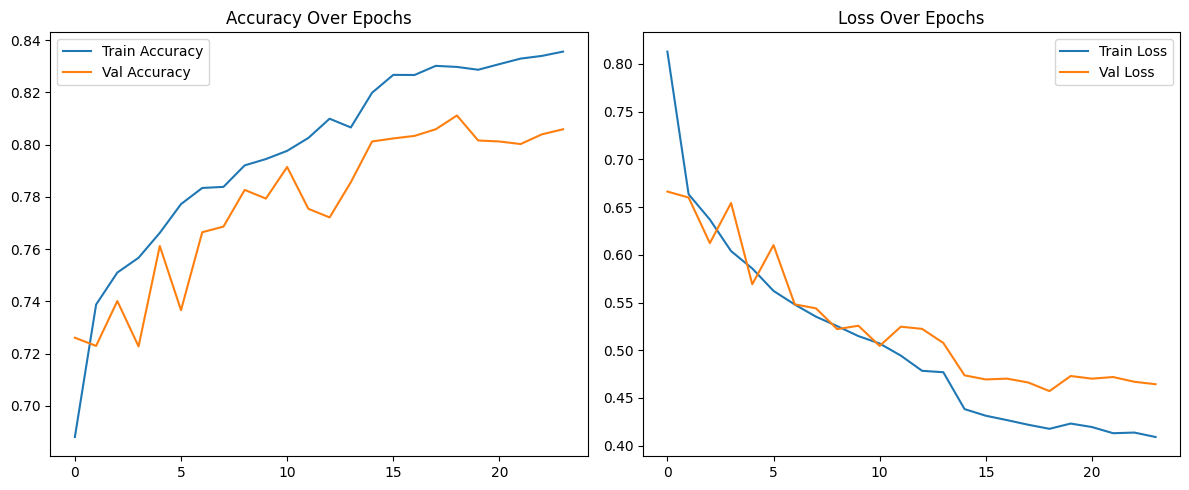

161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step


In [25]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# %%
# Generate predictions
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes


Classification Report:
               precision    recall  f1-score   support

fall armyworm       0.94      0.84      0.89       284
   grasshoper       0.93      0.95      0.94       411
      healthy       0.71      0.66      0.68       211
  leaf beetle       0.95      0.97      0.96       950
  leaf blight       0.67      0.84      0.74      1004
    leaf spot       0.77      0.61      0.68      1261
 streak virus       0.83      0.86      0.85      1004

     accuracy                           0.81      5125
    macro avg       0.83      0.82      0.82      5125
 weighted avg       0.82      0.81      0.81      5125



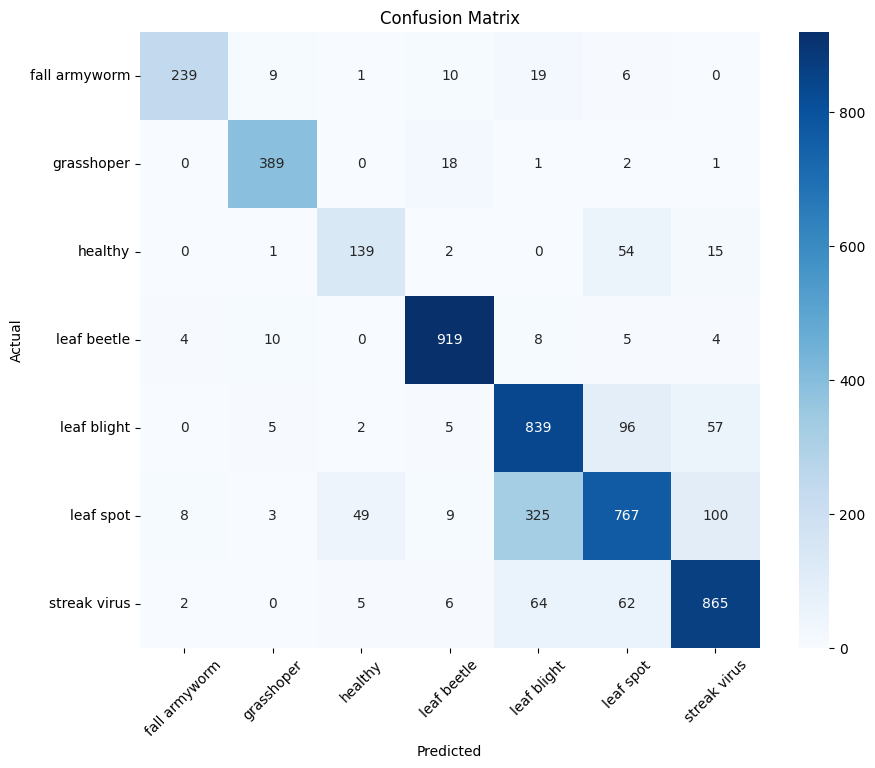

In [26]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=categories))

# %%
# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

plot_confusion_matrix(y_true, y_pred_classes, categories)


In [27]:
# Save full model
model.save('maize_disease_model.h5')

# %%
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Quantization
tflite_model = converter.convert()

# Save TFLite model
with open('maize_disease_model.tflite', 'wb') as f:
    f.write(tflite_model)

# %%
# Download files
from google.colab import files
files.download('maize_disease_model.tflite')
files.download('class_indices.json')

# %% [markdown]
"""
## Analysis Summary

**Key Metrics:**
- Final Validation Accuracy: {history.history['val_accuracy'][-1]:.2%}
- Model Size: {os.path.getsize('maize_disease_model.tflite')/1024:.1f} KB (quantized)

**Top 3 Confusion Pairs:**
1. {most_confused[0][0]} ↔ {most_confused[0][1]}
2. {most_confused[1][0]} ↔ {most_confused[1][1]}
3. {most_confused[2][0]} ↔ {most_confused[2][1]}

**Recommendations:**
1. Add more samples of {least_performing_class}
2. Implement test-time augmentation
3. Fine-tune last 5 MobileNet layers
"""

Saved artifact at '/tmp/tmp96acv11e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_92')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  135190516129360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135187634088912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135187634089104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135190507085968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135190507085584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135187634586448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135187634086800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135187634079312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135187634089488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135187634089296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13518763408

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

"\n## Analysis Summary\n\n**Key Metrics:**\n- Final Validation Accuracy: {history.history['val_accuracy'][-1]:.2%}\n- Model Size: {os.path.getsize('maize_disease_model.tflite')/1024:.1f} KB (quantized)\n\n**Top 3 Confusion Pairs:**\n1. {most_confused[0][0]} ↔ {most_confused[0][1]}\n2. {most_confused[1][0]} ↔ {most_confused[1][1]}\n3. {most_confused[2][0]} ↔ {most_confused[2][1]}\n\n**Recommendations:**\n1. Add more samples of {least_performing_class}\n2. Implement test-time augmentation\n3. Fine-tune last 5 MobileNet layers\n"